# Image Segmentation by Clusters

In this track you're asked to perform image segmentation by the cluster algorithms. One of them, K-means, was discussed in the lecture and classes, while the method of Fuzzy C-means *(FCM)* Clustering might be new for you.

## Marking criteria: 

- **6 points**: Do image segmentation with K-means;
- **7 points**: Finish the implementation of FCM algorithm;
- **2 points**: Compare the performance of algorithms.

## 1. Segmentation by K-means++ [6 points]

### 1.1 Prepare the data [1 points]

You're going to work with the real dataset that people use for the training of modern neural networks, yet sampled from GTA V. The reason of such sampling - is the ability to generate tons of *labeled* data, one of the key components of deep learning. However, the clustering algorithms in your assignment do not require so many images and you will use these images for validation only. 


Write a function that reads all the images in the given directory, load them as `cv.mat`, convert to grayscale, flatten it into a one dimensional array and convert from byte. The function should return two lists:
1) list of 1D `numpy.float32` arrays - the **flatten** grayscale images. These arrays will be used in clustering procedure;
2) list of 2D `numpy.uint8` grayscale images. They might help for visualization of the segmented images.


Module `os` might be useful to navigate through the files. 

***Do not use any additional libraries***

In [30]:
import numpy as np
import cv2
import os 

path = "data/images/"

def read_images(path):
    grayscale_images = []
    original_images = []
    for filename in os.listdir(path):
        if not filename.startswith("."):
            img = cv2.imread(os.path.join(path, filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            grayscale_images.append(np.float32(img.flatten()))
            original_images.append(img)
    return grayscale_images, original_images

grayscale_images, original_images = read_images(path)


### 1.2 Do a segmentation with K-means [5 points]

K-means can segment an image by the similarity of colors for each pixel. While it's not a semantic segmentation (i.e. segmentation of object on the image), the resulting image might be useful, for example, as a compression of the original one. 

Implement an image segmentation algorithm by K-means. Choose the number of clusters from 3 to 7. Fit the **flatten grayscale** images from the previous step to your algorithm. At the end you should get an array with the assignment of each pixel to some cluster. Reshape this array to the shape of the original image, set some colors to the clusters (to distinguish them) and do a visualization. Note that in this task you're **not** asked to implement K-means by yourself. 

***You're allowed to use any libraries***

Example of the original and segmented images. You might get another color scheme in segmentation, and it's fine, but please make sure that the clusters are distinguishable: 


![Original](data/original.png)

![Segmented](data/segmented.png)

/home/roukaya/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


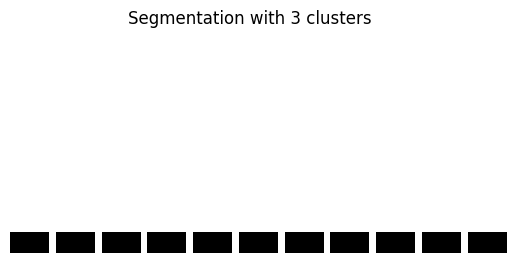

/home/roukaya/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


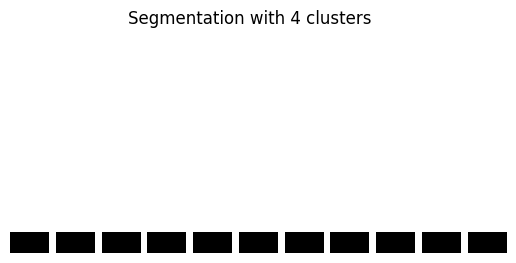

/home/roukaya/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


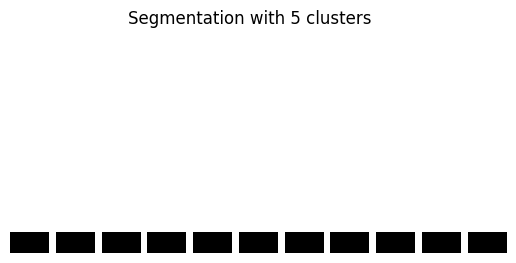

/home/roukaya/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


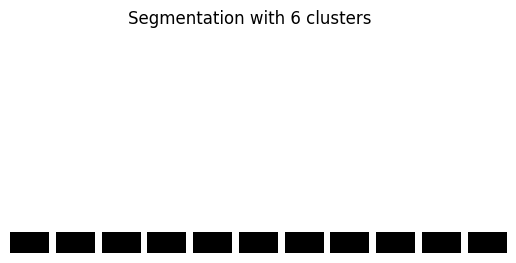

/home/roukaya/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


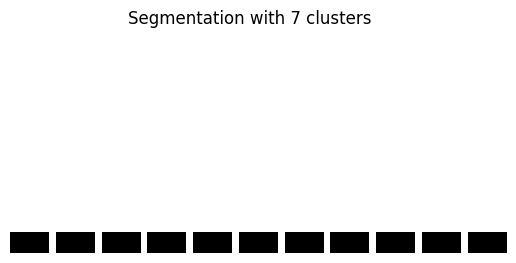

In [31]:
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans

for n_clusters in range(3, 8):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
    kmeans.fit(grayscale_images)
    cluster_assignments = kmeans.predict(grayscale_images)
    for i in range(len(original_images)):
        img = original_images[i].copy()
        img = img.reshape(-1)
        for cluster_index in range(n_clusters):
            img[cluster_assignments[i] == cluster_index] = (255 // (n_clusters - 1)) * cluster_index
        img = img.reshape(original_images[i].shape)
        plt.subplot(1, len(original_images), i+1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.suptitle(f'Segmentation with {n_clusters} clusters')
    plt.show()

## 2. Segmentation by Fuzzy Clustering [9 points]

Fuzzy clustering algorithms might be more preferable for the segmentation task than K-means. Instead of assigning each pixel (or data point in general) to only one cluster, a fuzzy method calculates the probability of belonging to each cluster for the pixel. Such probability, or **membership value** from $i-th$ data point to $j-th$ cluster, are combined into the **membership matrix** $W$ in a such way:

$\sum_{j=0}^C W_{i,j} = 1$

for any data point $i$, where $C$ - number of clusters. With this definition of a membership matrix the one should minimize this objective function to get the optimal values of clusters' centroids $c_j$:

$J = \sum_{i=0}^N \sum_{j=0}^C W_{i,j}^m \|x_i - c_j\|^2$ 

where $c_j$ is a cluster's centroid, $N$ - number of data points. $m$ - is a hyperparameter controlling the "fuzziness" of the clusters: the bigger this figure the closer the centroids are to each other; it is set at the beginning of the procedure. The membership value is calculated like this:

$W_{i,j} = {1 \over {\sum_{k=0}^C {(\|x_i - c_j\|) \over (\|x_i - c_k\|)}^{{2 \over m-1}} }}$

The **centroids** are calculated by:

$c_k = { \sum_{i=0}^N W_{i,k}^m * x_i \over \sum_{i=0}^N W_{i,k}^m}$

Thus, **the algorithm** of minimization of the objective function for image segmentation is:

- Choose a number of clusters $C$, in our case it should be somewhere in the range 3-7. Also choose the $m$ parameter from 2 to 5;
- Flatten the grayscale image into an array with length $N$; 
- Initialize the membership matrix $W$ with shape $N$ x $C$; at the beginning the values can random from 0 to 1. Make sure that for each pixel sum of its weights is equal to 1;
- The procedure of $W$ and $c$ calculation is iterative, so you should define stop criteria. That might be just the maximum number of steps, or some small epsilon - the absolute difference between matrix $W$ before and after the next update. You can also set both of the criteria;
- Repeat until one of the stop criteria is satisfied:
1) Compute the centroid for each cluster by $c_k$ formula;
2) Update the membership matrix $W$ with new values of centroids $c_k$. 
- For each pixel assign a cluster with the highest value after finishing the algorithm. Reshape the array into the shape of the original image.

### 2.1 Complete the implementation of the Fuzzy C-Means Clustering [7 points]

Use the description of the algorithm above to implement . You can either implement your own class or functions, or finish the implementation in the template according to the comments. 

***Do not use any additional libraries***

In [44]:
import numpy as np
import math 
import cv2
# Write your code here

class MyClusteringAlg():
    
    # Constructor with common parameters 
    # n_clusters - number of clusters (recommended from 3 to 7)
    # n          - FCM hyperparameter to contol the spray of the clusters (recommended from 2 to 5)
    # epsilon    - stop factor, the minimum possible distance (Euclidian or Manhattan) between 
    #              membership matricies after and before update 
    # max_iter   - stop factor, maximum possible iteration in segmentImage()
    def __init__(self, n_clusters=4, m=3, epsilon=0.1, max_iter=100):
        self.n_clusters = n_clusters
        self.m = m
        self.epsilon = epsilon
        self.max_iter = max_iter
    
    # Initialize membership matrix at the beginning of segmentImage()
    def __initW(self, n):
        # Initialize the membership matrix with random values
        w = np.random.rand(n, self.n_clusters)
        # Normalize the membership matrix
        w /= np.sum(w, axis=1, keepdims=True)
        return w
    
    # Calculate membership matrix according to the formula in the description of alg.
    def __updateWeightMat(self, X, centroids):
        n = X.shape[0]
        dists = np.linalg.norm(X[:, np.newaxis, :] - centroids, axis=-1)
        w = np.zeros((n, self.n_clusters))
        for i in range(self.n_clusters):
            w[:, i] = 1 / np.sum((dists[:, i, :] / dists) ** (2/(self.m-1)), axis=-1)
        w /= np.sum(w, axis=1, keepdims=True)
        return w
    
    # Calculate centroids according to the formula in the description of alg. 
    def __updateClusterCentroids(self, X, w):
        return np.dot(w.T, X) / np.sum(w, axis=0, keepdims=True).T
    
    # The main function of class that implements the whole algorithm 
    # Inputs the original grayscale image, returns its segmented version
    def segmentImage(self, image: np.array) -> np.array:
        X = image.reshape(-1, 1)
        n = X.shape[0]
        w = self.__initW(n)
        for i in range(self.max_iter):
            centroids = self.__updateClusterCentroids(X, w)
            new_w = self.__updateWeightMat(X, centroids)
            if np.linalg.norm(new_w - w) < self.epsilon:
                break
            w = new_w
        segmented_image = w.argmax(axis=1).reshape(image.shape)
        return segmented_image


### 2.2 K-means++ VS Fuzzy C-Means: Compare the performance [2 point]

Now you have two sets of the segmented images and labels in `data/` directory. All of these images have their own labeling of clusters, yet may segment the same instances. For example, vectors (that can be some part of segmented image) *1,1,1,0* and *75, 75, 75, 74* have quite a distance in Euclidean metric, but they are obviously correlated. 

That's why we cannot compare the images directly by pixels and will use ***cosine similarity***. Your task is: 

1) Calculate the average similarity between every segmented images from K-means and C-means and ground truth images in `data/labels`;
2) The average similarity of two images is calculated as follows. Compute the cosine similarity of **every rows** (pairwise) in images, take its absolute values, sum up the and divide by number of row pairs (i.e. height of image);
3) The higher similarity is considered as better clustering. Comment about the quality of C-means and K-means.
4) (*Recommended, but not necessary task*) How else would you measure the quality of segmentation?


***You're allowed to use any libraries***

In [45]:
import os
import cv2
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

cmeans_imgs = []
for img in grayscale_images: 
    fcm = MyClusteringAlg()
    segmented_img = fcm.segmentImage(img)
    cmeans_imgs.append(segmented_img)

kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
kmeans.fit(grayscale_images)
cluster_assignments = kmeans.predict(grayscale_images)
kmeans_imgs = []
for i in range(len(original_images)):
    img = original_images[i].copy()
    img = img.reshape(-1)
    for cluster_index in range(n_clusters):
        img[cluster_assignments[i] == cluster_index] = (255 // (n_clusters - 1)) * cluster_index
    img = img.reshape(original_images[i].shape)
    kmeans_imgs.append(img)

num_images = kmeans_imgs.shape[0]

# calculate the average cosine similarity between each k-means image and its corresponding label image
kmeans_similarities = []
for i in range(num_images):
    similarity_sum = 0
    for j in range(kmeans_imgs.shape[1]):
        similarity = cosine_similarity(kmeans_imgs[i][j].reshape(1,-1), label_imgs[i][j].reshape(1,-1))[0][0]
        similarity_sum += abs(similarity)
    avg_similarity = similarity_sum / kmeans_imgs.shape[1]
    kmeans_similarities.append(avg_similarity)

cmeans_similarities = []
for i in range(num_images):
    similarity_sum = 0
    for j in range(cmeans_imgs.shape[1]):
        similarity = cosine_similarity(cmeans_imgs[i][j].reshape(1,-1), label_imgs[i][j].reshape(1,-1))[0][0]
        similarity_sum += abs(similarity)
    avg_similarity = similarity_sum / cmeans_imgs.shape[1]
    cmeans_similarities.append(avg_similarity)

mean_kmeans_similarity = sum(kmeans_similarities) / len(kmeans_similarities)
mean_cmeans_similarity = sum(cmeans_similarities) / len(cmeans_similarities)

print("Mean similarity between k-means and labels:", mean_kmeans_similarity)
print("Mean similarity between c-means and labels:", mean_cmeans_similarity)


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

### References

https://towardsdatascience.com/fuzzy-c-means-clustering-with-python-f4908c714081

https://en.wikipedia.org/wiki/Fuzzy_clustering